In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2


Bad key savefig.frameon in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or

In [2]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

# import data

In [4]:
score = np.load('./data/band_score.npy')
ratemap = np.load('./data/rate_map.npy')
activations_theta = np.load('./data/activations_theta.npy')

# band score

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy.optimize import curve_fit

def band_score(rate,res):
    X,Y = np.meshgrid(np.linspace(-2,2,res),np.linspace(-2,2,res))
    x_flat,y_flat = X.flatten(), Y.flatten()
    loc = np.stack([x_flat,y_flat])

    # 计算频谱
    def spectrum(ratemap):
        res = ratemap.shape[0]
        fft_rate = np.abs(nf.fftshift(nf.fft2(ratemap)))
        fft_rate[:int(res/2),:] = 0
        return fft_rate
    ratemap = rate.reshape(res,res)
    fft_rate = spectrum(ratemap)

    # 定义高斯函数
    def gaussian(loc, A, k, phi, sigma):
        x = loc[0]
        y = loc[1]
        return A * np.exp(-((x - k*np.cos(phi))**2 / (2 * sigma**2) + (y - k*np.sin(phi))**2 / (2 * sigma**2)))

    initial_guess = [1.0, 0.2, 0.0, 0.1]

    try:
        params, _ = curve_fit(lambda xy, A, k, phi, sigma: gaussian(xy, A, k, phi, sigma), 
                                (loc), 
                                fft_rate.ravel(), 
                                p0=initial_guess, 
                                bounds=([0, 0.2, 0, 0.05], [np.inf, 1, np.pi, 0.5]),
                                maxfev=1000)  # 增加最大函数评估次数
    except RuntimeError as e:
        # print("Warning:", e)
        # 使用 `full_output=True` 调用 leastsq 获取最后一步的参数
        from scipy.optimize import leastsq
        params, _, _, _, _ = leastsq(
            lambda xy: fft_rate.ravel() - gaussian(loc, *xy), initial_guess or np.ones(len(initial_guess)), full_output=True, maxfev=1000
        )
        # print("Returning last known parameters:", params)
    # return popt, pcov
    dx = 4.4/res
    k0 = params[1]
    phi = params[2]
    sigma = params[3]
    kx = k0*np.cos(phi)/2*(1/dx/2)*np.pi*2
    ky = k0*np.sin(phi)/2*(1/dx/2)*np.pi*2
    k = np.sqrt(kx**2+ky**2)# The maximum frequency is 1/dx, correspoding k = np.pi*2/dx
    # print(params)
    gx = gaussian(loc, params[0], params[1], params[2], params[3])

    # 计算相关性
    band_scores = np.dot(fft_rate.ravel(), gx.ravel()) / (1e-8+np.linalg.norm(fft_rate.ravel()) * np.linalg.norm(gx.ravel())) / sigma

    return band_scores, ratemap, params, fft_rate, gx, k, phi, sigma

In [6]:
from tqdm import tqdm
import numpy as np

res = 50

data = np.load('./data/rate_map.npy')
print(data.shape)
Ng = data.shape[0]
T = data.shape[1]
score = np.zeros(Ng,)
k = np.zeros(Ng,)
phi = np.zeros(Ng,)
sigma = np.zeros(Ng,)
ratemap = np.zeros([Ng,50,50])
for i in tqdm(range(Ng)):
    rate = data[i]-np.mean(data[i])
    band_scores, rm, params, fft_rate, gx, k[i], phi[i], sigma[i] = band_score(rate,res)
    ratemap[i] = rm
    score[i] = band_scores

  0%|          | 7/4096 [00:00<01:06, 61.71it/s]

(4096, 2500)


  3%|▎         | 123/4096 [00:01<01:14, 53.40it/s]

100%|██████████| 4096/4096 [01:10<00:00, 57.77it/s]


Text(0.5, 1.0, 'band score distribution')

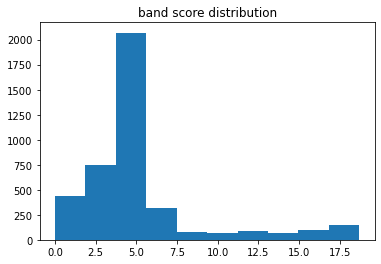

In [7]:
plt.hist(score)
plt.title('band score distribution')

# direction score

In [8]:
# direction score
from scipy.optimize import curve_fit
Ng = 4096

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def direction_scores(activations_theta=activations_theta, Ng=Ng):
    scores = []
    A_params = []
    mu_params = []
    sigma_params = []
    theta = np.linspace(-np.pi, np.pi, activations_theta.shape[1])
    
    for i in range(Ng):
        y_data = activations_theta[i]
        
        # Fit the Gaussian function to the data
        try:
            popt, _ = curve_fit(gaussian, theta, y_data, p0=[1, 0, 1])
            fitted_curve = gaussian(theta, *popt)
            
            # Calculate cosine similarity
            cos_sim = np.dot(y_data, fitted_curve) / (np.linalg.norm(y_data) * np.linalg.norm(fitted_curve))
            scores.append(cos_sim)
            
            # Save the parameters
            A_params.append(popt[0])
            mu_params.append(popt[1])
            sigma_params.append(popt[2])
        except RuntimeError:
            scores.append(0)
            A_params.append(0)
            mu_params.append(0)
            sigma_params.append(0)
    
    return np.array(scores), np.array(A_params), np.array(mu_params), np.array(sigma_params)

direction_scores, A_params, mu_params, sigma_params = direction_scores()

/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


(array([1.667e+03, 1.400e+01, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 7.000e+00, 1.000e+01, 2.065e+03]),
 array([-1.76592417e-07,  9.99998411e-02,  1.99999859e-01,  2.99999876e-01,
         3.99999894e-01,  4.99999912e-01,  5.99999929e-01,  6.99999947e-01,
         7.99999965e-01,  8.99999982e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

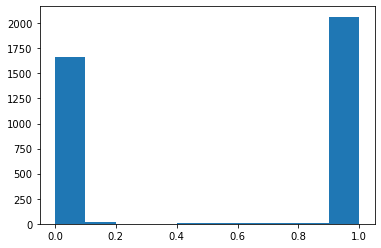

In [9]:
plt.hist(direction_scores)

selected cell number: 225


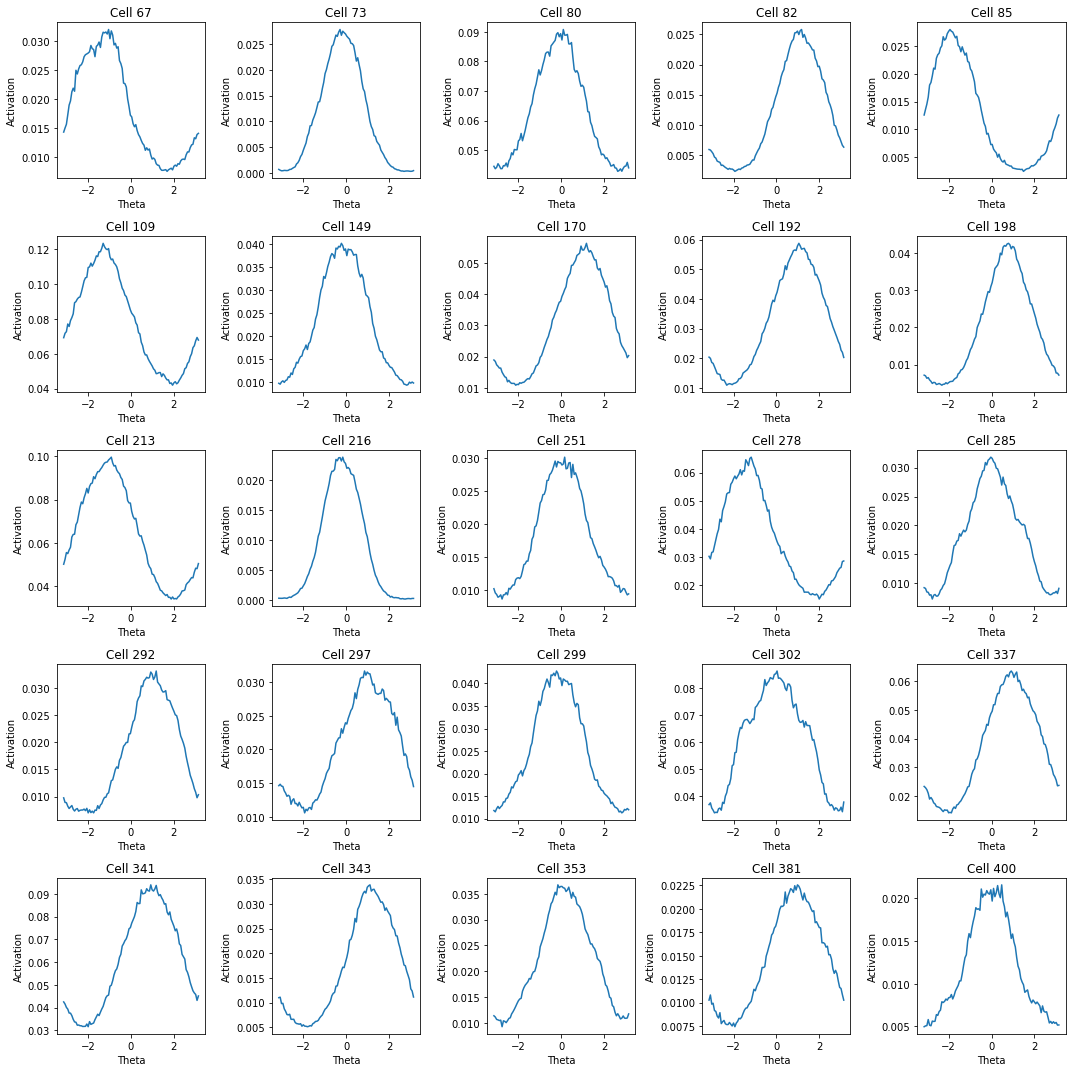

In [10]:
# 绘制direction比较高的orientation tuning
score_thres = 8.0
index = np.argsort(-score)
index_direction = np.where((direction_scores > 0.9) & (A_params > 0.01) & (np.abs(sigma_params) < 4))[0]
index_band = np.intersect1d(index_direction, np.where(score > score_thres)[0])

n_sub = 5
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
print('selected cell number:', index_band.shape[0])

theta = np.linspace(-np.pi, np.pi, res * 2)
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].plot(theta, activations_theta[index_band[i]])
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x, y].set_xlabel('Theta')
    ax[x, y].set_ylabel('Activation')

plt.tight_layout()
plt.show()

相位差

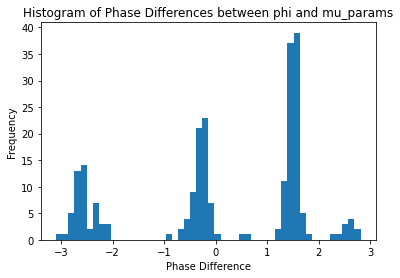

In [11]:
# 计算phi和mu的相位差
phase_diff = np.angle(np.exp(1j * (phi - mu_params)))
plt.hist(phase_diff[index_band], bins=50)
plt.xlabel('Phase Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Phase Differences between phi and mu_params')
plt.show()

selected cell number: 48


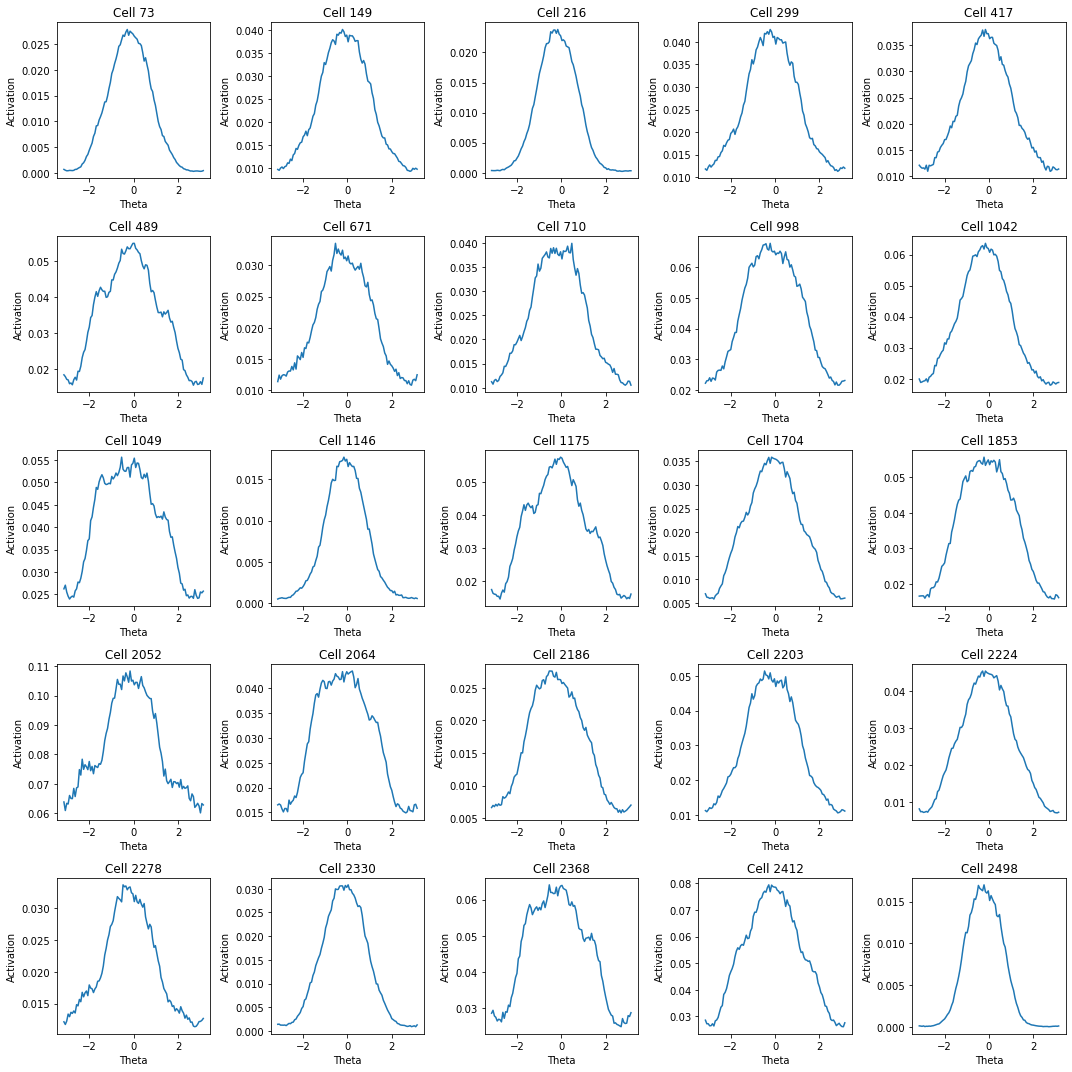

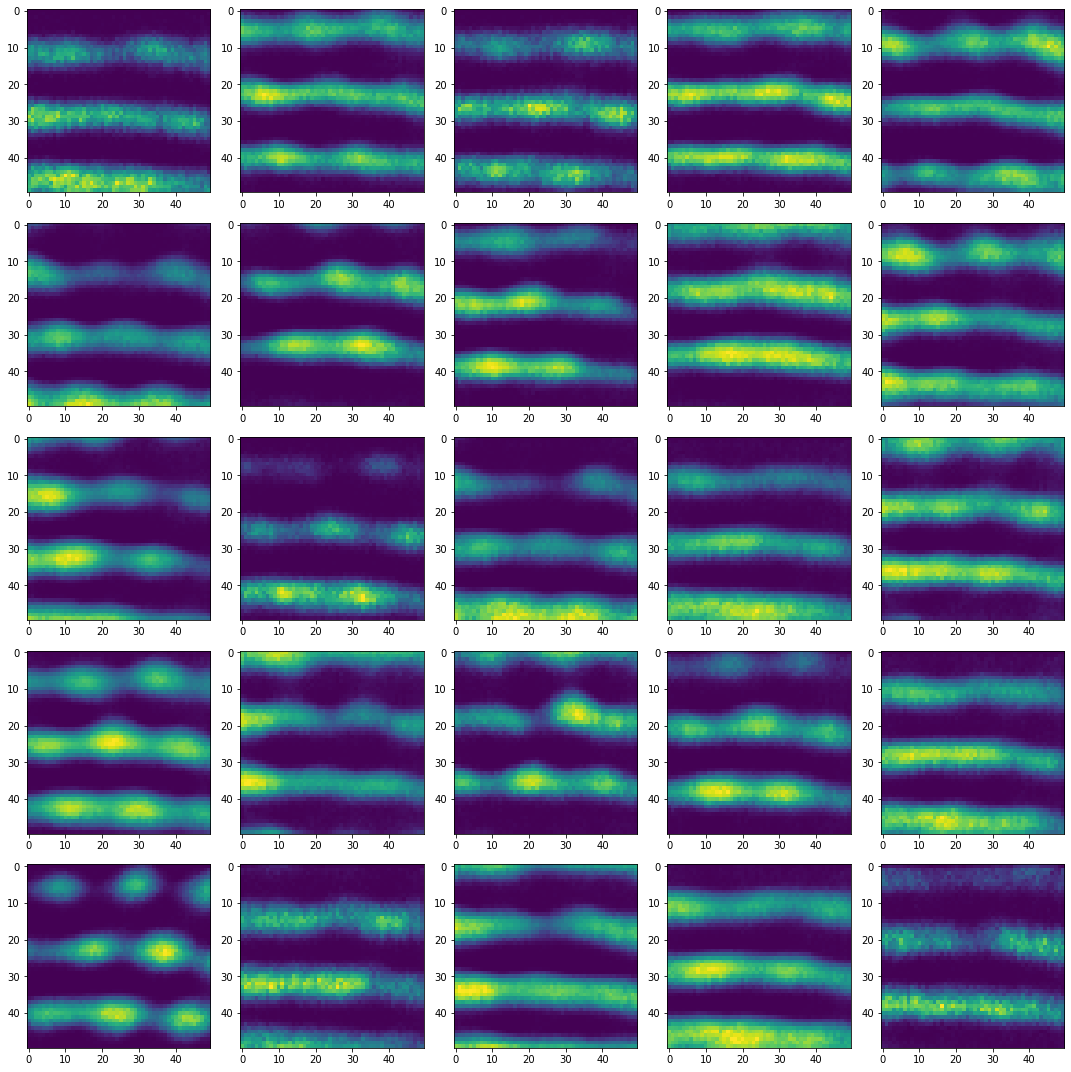

In [12]:
stange_idx_ = np.where((phase_diff > 1.5) & (phase_diff < 1.7))[0]
# stange_idx_ = np.where((phase_diff > -0.3) & (phase_diff < 0.3))[0]
stange_idx = np.intersect1d(stange_idx_, index_band)
print('selected cell number:', stange_idx.shape[0])

n_sub = 5
res = 50
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
fig.patch.set_facecolor('white')  # 设置整个大图的背景颜色为红色
theta = np.linspace(-np.pi, np.pi, res * 2)
for i in range(min(n_sub**2, len(stange_idx))):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].plot(theta, activations_theta[stange_idx[i]])
    ax[x, y].set_title(f'Cell {stange_idx[i]}')
    ax[x, y].set_xlabel('Theta')
    ax[x, y].set_ylabel('Activation')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
fig.patch.set_facecolor('white')  # 设置整个大图的背景颜色为红色
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].imshow(ratemap[stange_idx[i]])
plt.tight_layout()
plt.show()

# 周期、朝向、权重

[1.74829746 1.76       1.76       ... 1.34128561 1.31073342 1.40912678]
(505,)


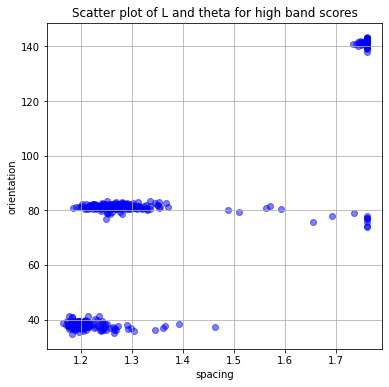

In [13]:
# 周期和朝向
L = 2*np.pi / k
print(L)

## 绘制 k_mag_opts 和 theta_opts 的散点图
plt.figure(figsize=(6, 6))
high_band_idxs = np.where(score > score_thres)[0]
print(high_band_idxs.shape)
plt.scatter(L[high_band_idxs], phi[high_band_idxs]/np.pi*180, c='blue', alpha=0.5)
plt.xlabel('spacing')
plt.ylabel('orientation')
plt.title('Scatter plot of L and theta for high band scores')
plt.grid(True)
plt.show()

(array([77., 70., 17.,  7.,  0.,  0.,  0.,  1.,  0., 53.]),
 array([1.16452129, 1.22406916, 1.28361703, 1.3431649 , 1.40271277,
        1.46226065, 1.52180852, 1.58135639, 1.64090426, 1.70045213,
        1.76      ]),
 <BarContainer object of 10 artists>)

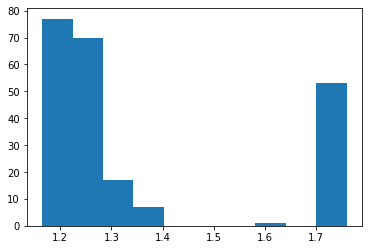

In [14]:
plt.hist(L[index_band])
# print(score)

(array([78.,  0.,  0.,  1., 94.,  0.,  0.,  0.,  0., 52.]),
 array([ 35.08959318,  45.90459173,  56.71959029,  67.53458884,
         78.3495874 ,  89.16458596,  99.97958451, 110.79458307,
        121.60958163, 132.42458018, 143.23957874]),
 <BarContainer object of 10 artists>)

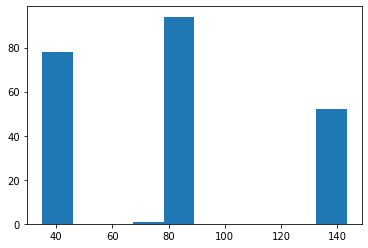

In [15]:
plt.hist(phi[index_band]/np.pi*180)

In [17]:
# 计算相位 phase
N_band = k.shape[0]
phase = np.zeros(N_band)  # 使用复数类型
# "loc" here is different from what we use in "band score", it's the real physical location
X,Y = np.meshgrid(np.linspace(-2.2,2.2,res),np.linspace(-2.2,2.2,res))
x_flat,y_flat = X.flatten(), Y.flatten()
loc = np.stack([x_flat,y_flat])

for i in range(high_band_idxs.shape[0]):
    j = 1j  # 虚部
    k_vec = np.array([k[high_band_idxs[i]]*np.cos(phi[high_band_idxs[i]]),k[high_band_idxs[i]]*np.sin(phi[high_band_idxs[i]])]).reshape(1,2) #1*2
    loc_phase = np.mod(np.dot(k_vec,loc), L[high_band_idxs[i]])/L[high_band_idxs[i]]*np.pi*2-np.pi #1*Ng
    phase[high_band_idxs[i]] = np.angle(np.sum(np.exp(loc_phase*1j)*rate)/np.sum(rate)) # 1

# print(phase)
# 

In [19]:
np.save('./data/phase.npy', phase)
np.save('./data/L.npy', L)

(array([ 13.,  21.,  29.,  15.,  27.,  40., 173., 121.,  40.,  26.]),
 array([-3.12115926, -2.495197  , -1.86923473, -1.24327247, -0.61731021,
         0.00865205,  0.63461431,  1.26057657,  1.88653883,  2.51250109,
         3.13846335]),
 <BarContainer object of 10 artists>)

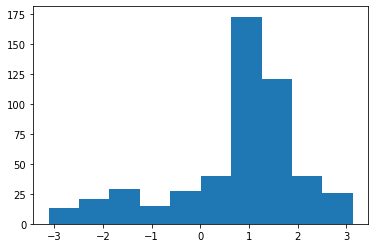

In [19]:
plt.hist(phase[high_band_idxs].reshape(-1,))

In [20]:
# 提取四个网络
high_band_idxs = np.where(score > score_thres)[0]

L_low_theta_low = np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 0) & (phi/np.pi*180 < 60))[0]
L_low_theta_mid= np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_mid = np.where((L > 1.7) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_high = np.where((L > 1.7) & (phi/np.pi*180 > 120))[0]

# 和high_band_idxs取交集
L_low_theta_low = np.intersect1d(L_low_theta_low, high_band_idxs)
L_low_theta_mid = np.intersect1d(L_low_theta_mid, high_band_idxs)
L_high_theta_mid = np.intersect1d(L_high_theta_mid, high_band_idxs)
L_high_theta_high = np.intersect1d(L_high_theta_high, high_band_idxs)

In [22]:
# 连接权重矩阵
J = np.load('./data/J_matrix.npy')

# 四个网络的连接权重矩阵
L_low_theta_low_idxs = L_low_theta_low[np.argsort(phase[L_low_theta_low])]
L_low_theta_mid_idxs = L_low_theta_mid[np.argsort(phase[L_low_theta_mid])]
L_high_theta_mid_idxs = L_high_theta_mid[np.argsort(phase[L_high_theta_mid])]
L_high_theta_high_idxs = L_high_theta_high[np.argsort(phase[L_high_theta_high])]

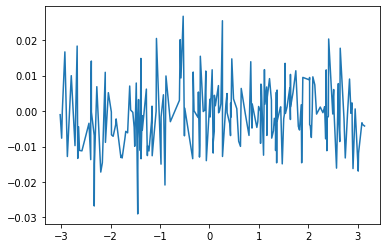

In [23]:
index_study = L_low_theta_mid_idxs
phases_study = phase[index_study]
weights = J[index_study][:, index_study]
index_neuron = 101
plt.plot(phases_study,weights[index_neuron,:])
# plt.hist(weights.flatten())

(210,)


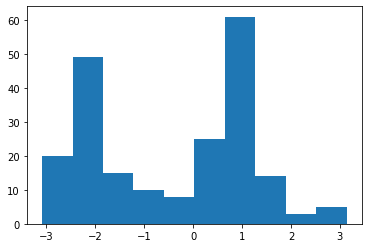

In [24]:

N_study = phases_study.shape[0]
phase_bias = np.zeros(N_study) 
for i in range(N_study):
    phase_bias[i] = np.angle(np.sum(np.exp(phases_study*1j)*weights[i,:])/np.sum(weights[index_neuron,:])) #index_neuron是怎么选的

plt.hist(phase_bias)
print(phase_bias.shape)

/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


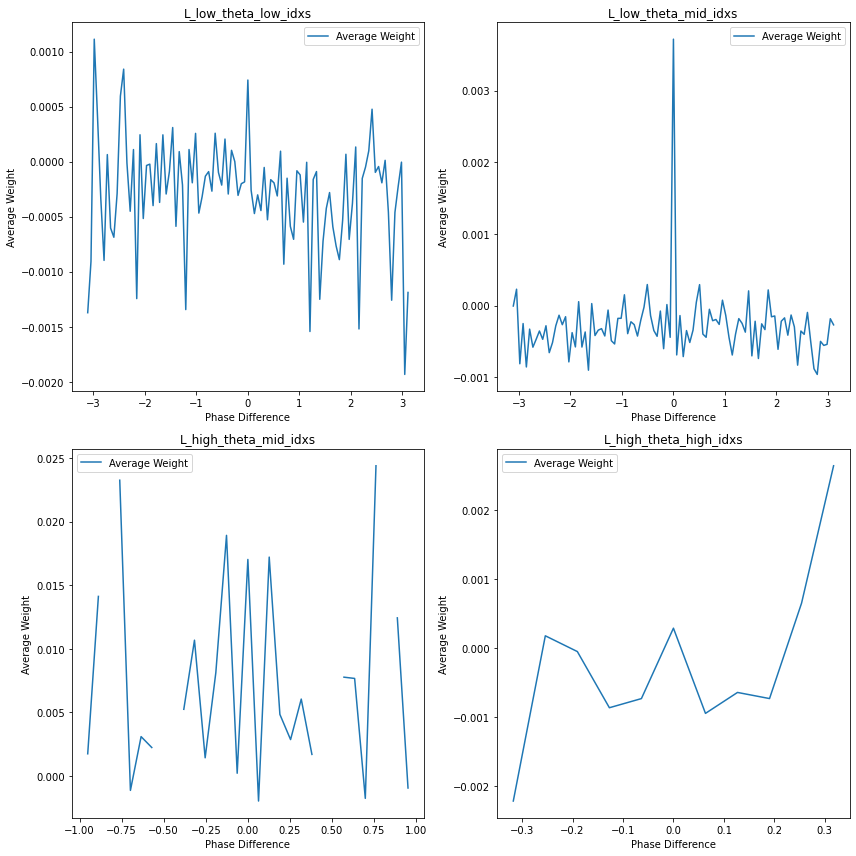

In [25]:
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff

# Calculate average weights as a function of phase difference
def average_weights_vs_phase_diff(idxs):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    phase_diff = phase_difference(phases)
    
    # Flatten the arrays
    phase_diff_flat = phase_diff.flatten()
    weights_flat = weights.flatten()
    
    # # Filter weights to include only those greater than 0
    # positive_weights_mask = weights_flat > 0
    # phase_diff_flat = phase_diff_flat[positive_weights_mask]
    # weights_flat = weights_flat[positive_weights_mask]
    
    # Bin the phase differences
    bins = np.linspace(-np.pi, np.pi, 100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    digitized = np.digitize(phase_diff_flat, bins) - 1
    
    # Calculate the average weight for each bin
    avg_weights = np.array([weights_flat[digitized == i].mean() for i in range(len(bin_centers))])
    
    return bin_centers, avg_weights

# Plot average weights as a function of phase difference
def plot_average_weights_vs_phase_diff(ax, idxs, title):
    bin_centers, avg_weights = average_weights_vs_phase_diff(idxs)
    ax.plot(bin_centers, avg_weights, label='Average Weight')
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Average Weight')
    ax.set_facecolor('white')  # Set background color to white
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot L_low_theta_low_idxs
plot_average_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
plot_average_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
plot_average_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
plot_average_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
plt.show()

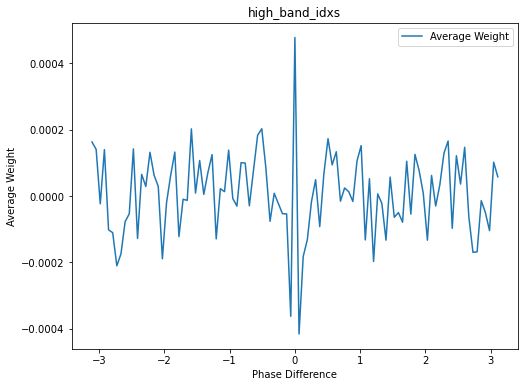

In [26]:
# 四个网络的叠加
high_band_idxs = np.where(score > score_thres)[0]

# high_band_idxs
fig, ax = plt.subplots(figsize=(8, 6))
plot_average_weights_vs_phase_diff(ax, high_band_idxs, 'high_band_idxs')
plt.show()

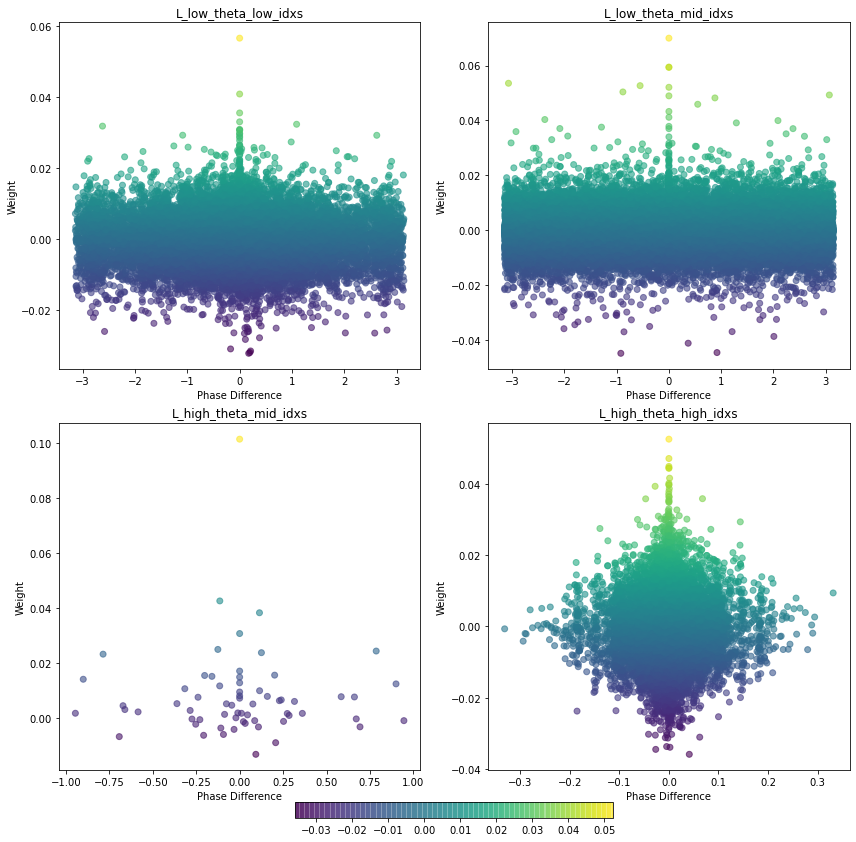

In [27]:
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff

# Plot weights as a function of phase difference
def plot_weights_vs_phase_diff(ax, idxs, title):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    phase_diff = phase_difference(phases)
    
    sc = ax.scatter(phase_diff.flatten(), weights.flatten(), c=weights.flatten(), cmap='viridis', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Weight')
    ax.set_facecolor('white')  # Set background color to white
    return sc

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot L_low_theta_low_idxs
sc = plot_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
sc = plot_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
fig.colorbar(sc, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()